In [1]:
import numpy as np
from PIL import Image
import glob

> #### 이전 까지는 해상도를 평균값으로 했다.
> #### 이렇게 되면 데이터가 손실되는 이미지가 생기기 떄문에 최대 해상도로 맞추는 것이 맞다.

---
### 전체 사진중 최대 해상도 찾기

In [2]:
dirNames = ['Aiden','Andrew','Cathy']

In [3]:
width = []
height = []

for i in dirNames:
    for file in sorted(glob.glob(f'./Data/Face/{i}/*.jpg')):
        img = Image.open(file)
        img = np.array(img,dtype=np.int32)
        width.append(img.shape[1])
        height.append(img.shape[0])

print('max width :',np.max(width),', max height :' , np.max(height))

max width : 299 , max height : 381


### 이미지 센터에 맞추기
- height : 400 , width : 300 인 이미지로 resize 하자. <br><br>
- 하지만 이 때 이것보다 작은 이미지들을 이 사이즈에 넣게 되면 여백이 생기게 된다. <br><br>
- 따로 조정을 하지 않으면 작은 이미지들을 고정 사이즈로 바꾸게 되면 왼쪽 위에 붙게 되므로 이를 센터에 오게끔 하는 작업이 필요하다. <br><br>

In [4]:
# 전체 fileName 가져오기
for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob(f'./Data/Face/{name}/*.jpg')):
        img = Image.open(file)
        imgArray = np.array(img)
        
        # 400, 300 의 3 칼라 이미지 사이즈 만들기
        imgDummy = np.zeros(400 * 300 * 3).reshape(400,300,3)
        
        rowNum = (400 - imgArray.shape[0]) / 2
        columnNum = (300 - imgArray.shape[1]) / 2

        # imgDummy에 넣기
        k = 0
        for i in list( range(int(rowNum) , int(rowNum) + imgArray.shape[0])):
            l = 0
            for j in list( range(int(columnNum) , int(columnNum) + imgArray.shape[1])):
                imgDummy[i,j] = imgArray[k,l]
                l += 1
            k += 1
        
        img2 = Image.fromarray(imgDummy.astype('uint8'))
        img2.save('./Data/FaceColor/%s/image_%04d.jpg'%(name,fileCount),'JPEG')
        fileCount += 1

---
### FaceGray 이미지 가져오기

In [5]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400
img_color = 3

In [6]:
X = []
y = []

In [7]:
target = 0
i = 0
train  = np.zeros(54 * 300 * 400 * 3,dtype = np.int32).reshape(54,400,300,3)
for name in dirNames:
    
    for file in sorted(glob.glob(f'./Data/FaceColor/{name}/*.jpg')):
        img = Image.open(file)
        train[i] = np.array(img , dtype = np.int32)
        y.append(target)
        i += 1

    target += 1

In [8]:
train.shape

(54, 400, 300, 3)

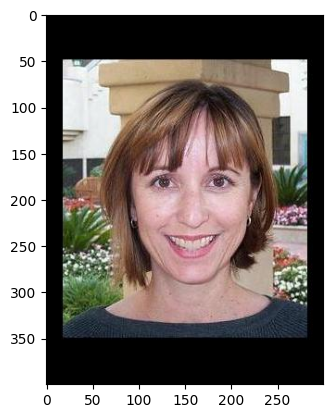

2


In [9]:
import matplotlib.pyplot as plt

plt.imshow(train[37],)

plt.show()

print(y[37])

### CNN 해보기

In [10]:
target = np.array(y.copy() ,dtype = np.int32)

In [11]:
train_scaled = train.reshape(-1,400,300,3) / 255.0

In [12]:
train_scaled.shape
target.shape

(54,)

In [13]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled , train_target , val_target = \
    train_test_split(train_scaled, target , test_size=0.2)

In [1]:
import sys
print(sys.version)

3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:26:40) [Clang 14.0.6 ]


In [15]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(
    32,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same',
    input_shape = (400,300,3)
))

# pooling
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Conv2D(
    64,
    kernel_size = 3,
    activation = 'relu',
    padding = 'same'
))

# pooling
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(3,activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 75, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 100)               4

In [17]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./Data/face-color-model.h5')
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

hist = model.fit(train_scaled,
                 train_target,
                 epochs=20,
                 validation_data = (val_scaled,val_target),
                 callbacks=[checkpoint_cb]
                 )

Epoch 1/20


2023-03-03 14:39:04.720123: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 7s 2s/step - loss: 7.0046 - accuracy: 0.3953 - val_loss: 14.7155 - val_accuracy: 0.3636
Epoch 2/20
2/2 [==============================] - 5s 2s/step - loss: 8.5380 - accuracy: 0.4419 - val_loss: 6.3810 - val_accuracy: 0.6364
Epoch 3/20
2/2 [==============================] - 5s 3s/step - loss: 4.7485 - accuracy: 0.5814 - val_loss: 2.3861 - val_accuracy: 0.6364
Epoch 4/20
2/2 [==============================] - 5s 3s/step - loss: 0.6704 - accuracy: 0.8372 - val_loss: 0.7263 - val_accuracy: 0.9091
Epoch 5/20
2/2 [==============================] - 5s 2s/step - loss: 0.0531 - accuracy: 0.9767 - val_loss: 0.8897 - val_accuracy: 0.8182
Epoch 6/20
2/2 [==============================] - 5s 2s/step - loss: 0.3253 - accuracy: 0.9302 - val_loss: 1.2012 - val_accuracy: 0.9091
Epoch 7/20
2/2 [==============================] - 5s 2s/step - loss: 0.0918 - accuracy: 0.9767 - val_loss: 1.5306 - val_accuracy: 0.9091
Epoch 8/20
2/2 [==============================] - 5

In [18]:
model.evaluate(val_scaled,val_target)

1/1 [==============================] - 0s 126ms/step - loss: 1.8408 - accuracy: 0.9091


[1.8407896757125854, 0.9090909361839294]

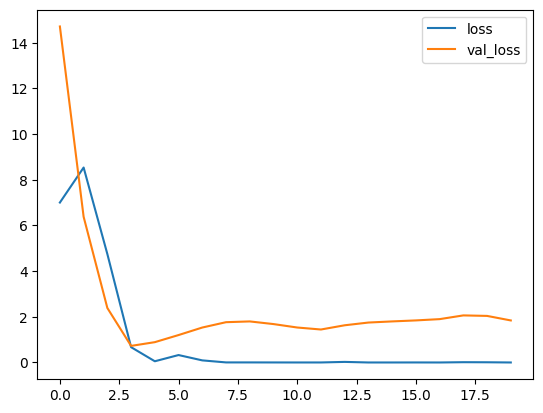

In [19]:
plt.plot(
    hist.history['loss'],
    label = 'loss'
)

plt.plot(
    hist.history['val_loss'],
    label = 'val_loss'
)

plt.legend()

plt.show()

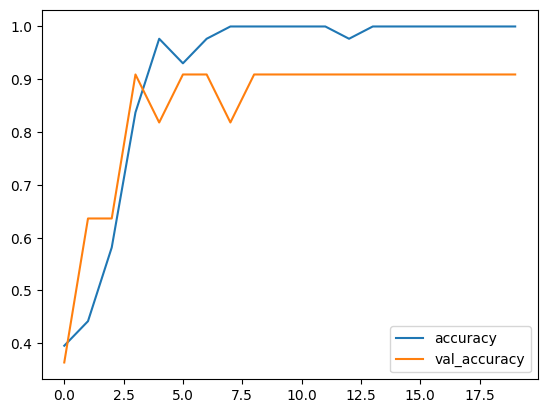

In [20]:
plt.plot(
    hist.history['accuracy'],
    label = 'accuracy'
)

plt.plot(
    hist.history['val_accuracy'],
    label = 'val_accuracy'
)

plt.legend()

plt.show()

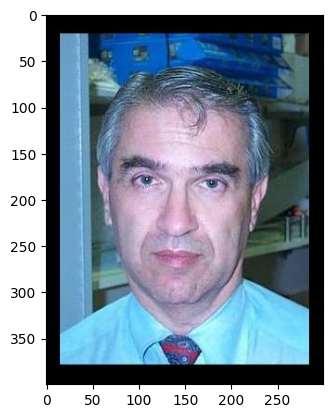

In [23]:
plt.imshow(train_scaled[0])

In [25]:
test = train_scaled[0].reshape(1,400,300,3)

In [27]:
np.argmax(model.predict(test))

1/1 [==============================] - 0s 27ms/step


1